In [1]:
import pandas as pd
import numpy as np
data_path = "/Users/edoardocamerinelli/Desktop/momentum_contrarian_unified/approaches/vectorized_contrarian_monthly/data/daily_equity_curve_6m_lookback.csv"

df = pd.read_csv(data_path)

In [ ]:
import pandas as pd
import numpy as np

# Calcolo robusto e vettoriale del filtro drawdown (nessun loop)
# Uso della serie già caricata in `df` (se non presente, viene ricaricata)
if 'df' not in globals():
    data_path = "/Users/edoardocamerinelli/Desktop/momentum_contrarian_unified/approaches/vectorized_contrarian_monthly/data/daily_equity_curve_6m_lookback.csv"
    df = pd.read_csv(data_path)

equity = df['cumulative_returns'].astype(float).values
eps = 1e-12

# massimo PRECEDENTE usando cummax() shifted -> nessun lookahead
roll_prev = pd.Series(equity).cummax().shift(1).fillna(equity[0]).values
roll_prev = np.where(roll_prev == 0, eps, roll_prev)

# drawdown rispetto al massimo precedente (vettoriale)
drawdown = (equity - roll_prev) / roll_prev

# soglia: quando drawdown <= threshold -> siamo
# rientro quando drawdown > threshold
threshold = -0.05
# stato al tempo t (1 investiti, 0 fuori) valutato su drawdown a t: vettoriale
state_at_t = (drawdown > threshold).astype(int)
# la decisione valutata a t vale effettivamente per t+1 (nessun wrap)
state = np.empty_like(state_at_t)
state[0] = 1  # primo giorno sempre investiti
state[1:] = state_at_t[:-1]

df['invested'] = state
print("✅ Filtro vettoriale applicato - primi 20 giorni:")
print(df[['Date', 'cumulative_returns', 'invested']].head(20))

# punti di uscita / rientro (stesso metodo di prima)
exit_points = df.index[(df['invested'].shift(1) == 1) & (df['invested'] == 0)].tolist()
entry_points = df.index[(df['invested'].shift(1) == 0) & (df['invested'] == 1)].tolist()
print(f"\nPunti di uscita: {len(exit_points)} - primi 10: {exit_points[:10]}")
print(f"Punti di rientro: {len(entry_points)} - primi 10: {entry_points[:10]}")

# Verifica vettoriale: ricostruisco lo stesso stato usando solo dati passati e confronto
roll_prev_check = pd.Series(equity).cummax().shift(1).fillna(equity[0]).values
roll_prev_check = np.where(roll_prev_check == 0, eps, roll_prev_check)
dd_check = (equity - roll_prev_check) / roll_prev_check
state_check_at_t = (dd_check > threshold).astype(int)
state_check = np.empty_like(state_check_at_t)
state_check[0] = 1
state_check[1:] = state_check_at_t[:-1]

mismatch = np.where(state != state_check)[0]
if len(mismatch) == 0:
    print("✔️ Verifica: nessun lookahead rilevato (state coincide con ricostruzione vettoriale)")
else:
    print("❌ Mismatch rilevati in posizioni:", mismatch[:10])
    for idx in mismatch[:10]:
        print(idx, equity[max(0, idx-2):idx+2], 'state=', state[idx], 'state_check=', state_check[idx])

✅ Filtro vettoriale applicato - primi 20 giorni:
          Date  cumulative_returns  invested
0   2000-08-23            1.000000         1
1   2000-08-24            1.000000         1
2   2000-08-25            1.000000         1
3   2000-08-28            1.000000         1
4   2000-08-29            1.000000         1
5   2000-08-30            1.000000         1
6   2000-08-31            1.000000         1
7   2000-09-01            0.993836         1
8   2000-09-05            0.966428         1
9   2000-09-06            0.975343         1
10  2000-09-07            0.999261         1
11  2000-09-08            0.990112         1
12  2000-09-11            1.000174         1
13  2000-09-12            1.003366         1
14  2000-09-13            1.038250         1
15  2000-09-14            1.033884         1
16  2000-09-15            1.013536         1
17  2000-09-18            1.036548         1
18  2000-09-19            1.026813         1
19  2000-09-20            1.058644         1

Punti

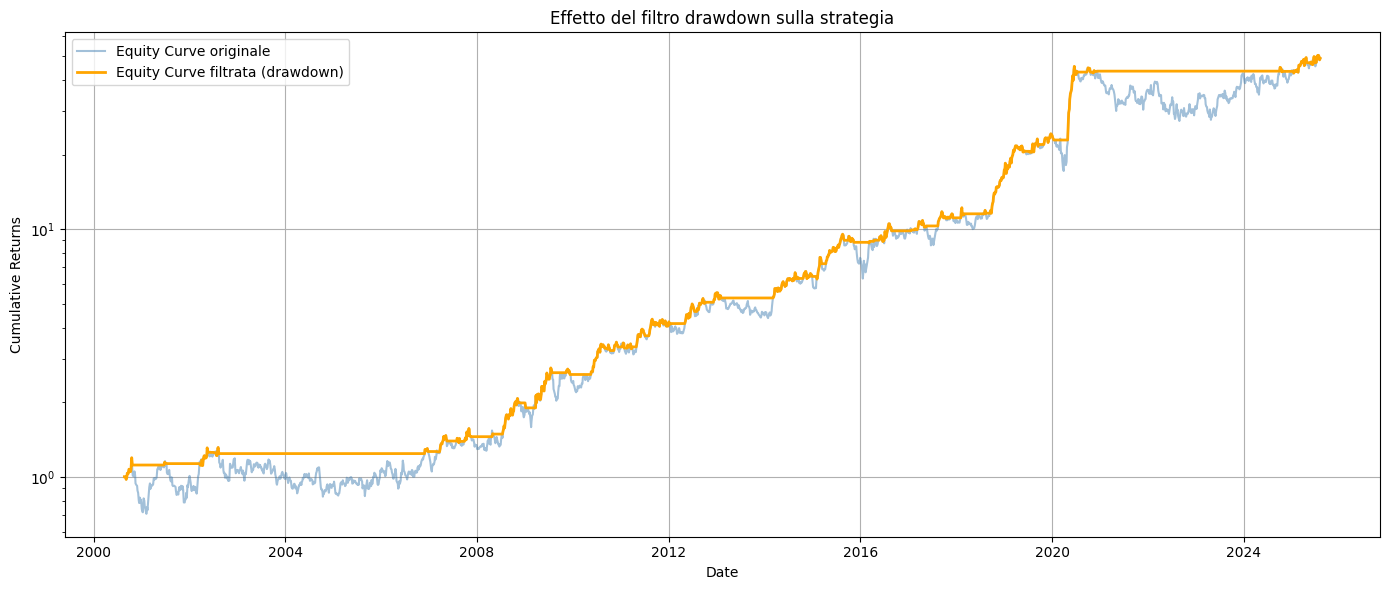

In [3]:
# Visualizzazione grafica della strategia con e senza filtro drawdown (corretto, log scale)
import matplotlib.pyplot as plt

# Assicura che la colonna Date sia datetime
if not np.issubdtype(df['Date'].dtype, np.datetime64):
    df['Date'] = pd.to_datetime(df['Date'])

# Calcola la curva filtrata: piatta nei periodi out
filtered_curve = df['cumulative_returns'].copy()
mask = df['invested'] == 0
filtered_curve[mask] = np.nan
filtered_curve = filtered_curve.ffill()

# Ottimizza il plot per DataFrame grandi
step = max(1, len(df) // 2000)

plt.figure(figsize=(14,6))
plt.plot(df['Date'][::step], df['cumulative_returns'][::step], label='Equity Curve originale', alpha=0.5, color='steelblue')
plt.plot(df['Date'][::step], filtered_curve[::step], label='Equity Curve filtrata (drawdown)', linewidth=2, color='orange')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Effetto del filtro drawdown sulla strategia')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

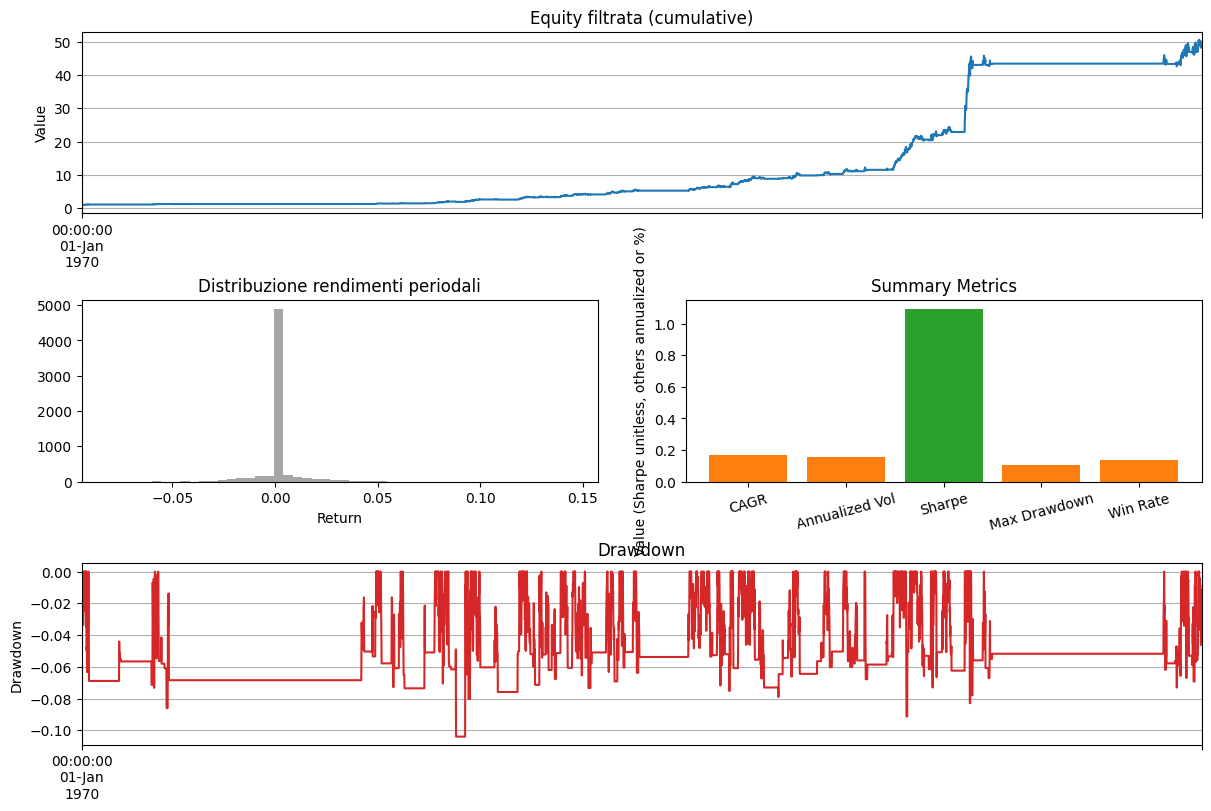


Performance summary:
CAGR                  0.1691
Annualized Return     0.1679
Annualized Vol        0.1534
Sharpe                1.0947
Max Drawdown         -0.1040
Win Rate              0.1365
Avg Win               0.0152
Avg Loss             -0.0124
Periods/Year        252.0000
Years                24.8611
dtype: float64


In [4]:
# Statistiche di performance per la equity filtrata (CAGR, Vol, Sharpe, MaxDD, Win rate)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Procuriamoci la series filtrata (ricostruzione robusta come nella cella precedente)
if 'ser' in globals():
    series = ser.copy()
elif 'equity_filt' in globals():
    series = pd.Series(equity_filt)
elif 'filtered_curve' in globals():
    series = filtered_curve.copy() if isinstance(filtered_curve, pd.Series) else pd.Series(filtered_curve)
    if 'df' in globals() and len(df) == len(series):
        series.index = df.index
else:
    if 'df' in globals() and 'invested' in df.columns and 'cumulative_returns' in df.columns:
        series = df['cumulative_returns'].copy()
        series[df['invested'] == 0] = np.nan
        series = series.ffill()
    else:
        raise NameError('Non riesco a ricostruire la equity filtrata (manca ser/equity_filt/filtered_curve o colonne in df)')

# Assicuriamoci numerica e indice datetime se possibile
series = series.astype(float)
try:
    series.index = pd.to_datetime(series.index)
except Exception:
    pass

# Determina periodi per anno (stima dalla frequenza dei dati)
periods_per_year = 252  # default
if isinstance(series.index, pd.DatetimeIndex) and len(series) > 1:
    diffs = np.diff(series.index.values).astype('timedelta64[D]').astype(int)
    median_days = int(np.median(diffs)) if len(diffs) > 0 else 1
    if median_days <= 3:
        periods_per_year = 252
    elif median_days > 25 and median_days <= 40:
        periods_per_year = 12
    elif median_days > 40:
        periods_per_year = 4
    else:
        periods_per_year = int(round(365 / median_days)) if median_days > 0 else 252

# Calcola rendimenti periodali (pct change)
rets = series.pct_change().dropna()
if rets.empty:
    raise ValueError('Serie filtrata troppo corta per calcolare rendimenti')

# Metriche
years = len(rets) / periods_per_year
cum_ret = (1 + rets).prod() - 1
cagr = (1 + cum_ret) ** (1 / years) - 1 if years > 0 else np.nan
ann_vol = rets.std() * np.sqrt(periods_per_year)
ann_ret = rets.mean() * periods_per_year
sharpe = ann_ret / ann_vol if ann_vol != 0 else np.nan

# Max drawdown (usa dd_series_filt se presente)
if 'dd_series_filt' in globals():
    max_dd = dd_series_filt.min()
else:
    roll_max = series.cummax()
    dd = (series / roll_max) - 1
    max_dd = dd.min()

win_rate = (rets > 0).sum() / len(rets)
avg_win = rets[rets > 0].mean()
avg_loss = rets[rets < 0].mean()

# Tabella risultati
stats = {
    'CAGR': cagr,
    'Annualized Return': ann_ret,
    'Annualized Vol': ann_vol,
    'Sharpe': sharpe,
    'Max Drawdown': max_dd,
    'Win Rate': win_rate,
    'Avg Win': avg_win,
    'Avg Loss': avg_loss,
    'Periods/Year': periods_per_year,
    'Years': years
}

# Plot: barra delle principali metriche + histogram rendimenti + equity cumulativa
fig = plt.figure(constrained_layout=True, figsize=(12, 8))
gs = fig.add_gridspec(3, 2)
ax0 = fig.add_subplot(gs[0, :])  # equity curve
ax1 = fig.add_subplot(gs[1, 0])  # histogram
ax2 = fig.add_subplot(gs[1, 1])  # bar metrics
ax3 = fig.add_subplot(gs[2, :])  # drawdown

# Equity curve
series.plot(ax=ax0, color='tab:blue')
ax0.set_title('Equity filtrata (cumulative)')
ax0.set_ylabel('Value')
ax0.grid(True)

# Histogram
ax1.hist(rets.dropna(), bins=50, color='grey', alpha=0.7)
ax1.set_title('Distribuzione rendimenti periodali')
ax1.set_xlabel('Return')

# Bar metrics (select few)
bar_keys = ['CAGR', 'Annualized Vol', 'Sharpe', 'Max Drawdown', 'Win Rate']
bar_vals = [stats[k] for k in bar_keys]
# Convert Max Drawdown to positive percentage for display
bar_display = [ (v if k!='Max Drawdown' else abs(v)) for k,v in zip(bar_keys, bar_vals) ]
ax2.bar(bar_keys, bar_display, color=['tab:green' if k=='Sharpe' else 'tab:orange' for k in bar_keys])
ax2.set_title('Summary Metrics')
ax2.set_ylabel('Value (Sharpe unitless, others annualized or %)')
ax2.tick_params(axis='x', rotation=15)

# Drawdown
if 'dd_series_filt' in globals():
    dd_plot = dd_series_filt
else:
    roll_max = series.cummax()
    dd_plot = (series / roll_max) - 1

dd_plot.plot(ax=ax3, color='tab:red')
ax3.set_title('Drawdown')
ax3.set_ylabel('Drawdown')
ax3.grid(True)

plt.show()

# Stampa tabella compatta
pd.set_option('display.float_format', '{:.4f}'.format)
print('\nPerformance summary:')
print(pd.Series(stats))
